In [1]:
import os
from ModularCirc.Models.KorakianitisMixedModel import KorakianitisMixedModel, KorakianitisMixedModel_parameters, TEMPLATE_TIME_SETUP_DICT
from ModularCirc import BatchRunner
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import pickle
from cvdnet_pipeline.utils import helper_functions, plot_utils

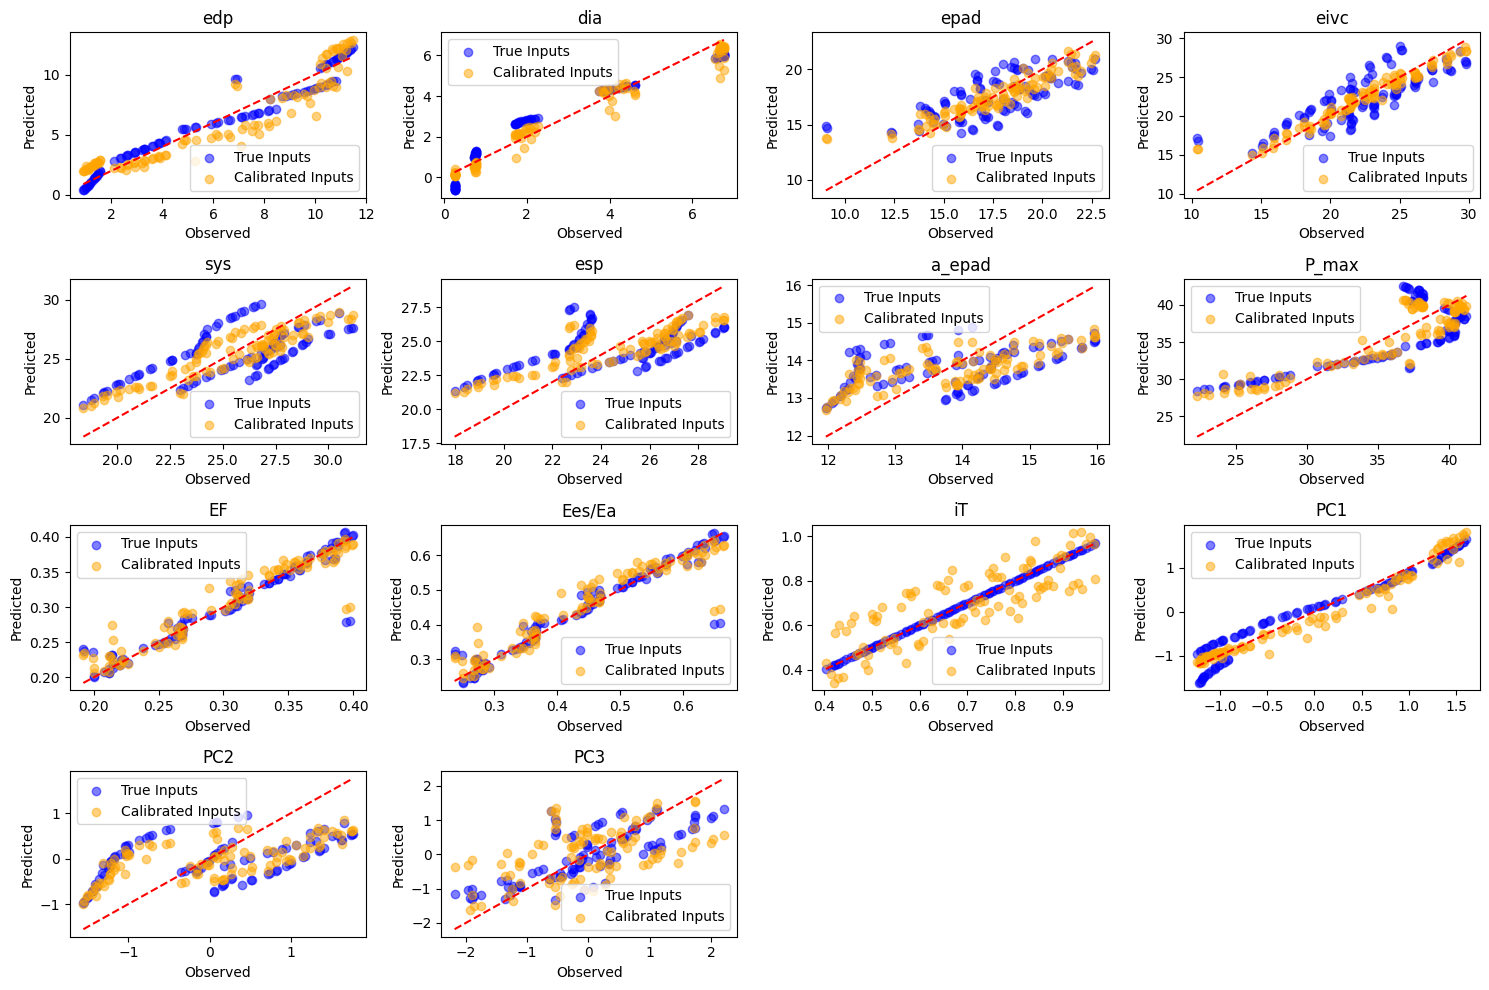

In [56]:
n_samples = 100
n_params = 9
data_type = "synthetic"
output_path = "../output_synthetic"

all_output_keys = [
        "edp",
        "dia",
        "epad",
        "eivc",
        "sys",
        "esp",
        "a_epad",
        "P_max",
        "EF",
        "Ees/Ea",
        "iT",
        "PC1",
        "PC2",
        "PC3"
    ]

calibration_path = "14_output_keys/kf_calibration_results/14_output_keys/calibration_20250924_152801/kf_estimated_means"

# Emulators
emulators= pd.read_pickle(f"{output_path}/output_{n_samples}_{n_params}_params/emulators/linear_models_and_r2_scores_{n_samples}.pkl")

# True imputs
true_inputs = pd.read_csv(f"{output_path}/pure_input_{n_samples}_{n_params}_params.csv")

# True outputs
true_output = pd.read_csv(f"{output_path}/output_{n_samples}_{n_params}_params/waveform_resampled_all_pressure_traces_rv_with_pca.csv")

# Calibrated inputs
calibrated_inputs = pd.read_csv(f"{output_path}/output_{n_samples}_{n_params}_params/kf_calibration_results/{calibration_path}.csv")

# Select emulators and data for specified output_keys
emulator_output = emulators.loc[all_output_keys]
observation_data = true_output.loc[:, all_output_keys] 

# Model error (RMSE from cross-validation)
model_error = np.array(emulator_output['RMSE']).reshape(14,1)

# Construct beta matrix and intercepts
beta_matrix = []
intercept = []

for _, row_entry in emulator_output.iterrows():
    model = row_entry['Model']
    beta_matrix.append(model.coef_)
    intercept.append(model.intercept_)

beta_matrix = np.array(beta_matrix)
intercept = np.array(intercept).reshape(len(intercept), 1)

# emulator predictions for true inputs
emulator_predictions_true = np.dot(beta_matrix, true_inputs.T) + intercept
emulator_predictions_true = pd.DataFrame(emulator_predictions_true.T, columns=all_output_keys)


# emulator predictions for calibrated inputs
emulator_predictions_calibrated = np.dot(beta_matrix, calibrated_inputs.T) + intercept 
emulator_predictions_calibrated = pd.DataFrame(emulator_predictions_calibrated.T, columns=all_output_keys)


# Plot results
plt.figure(figsize=(15, 10))
for i, key in enumerate(all_output_keys):
    plt.subplot(4, 4, i+1)
    plt.scatter(observation_data[key], emulator_predictions_true[key], label='True Inputs', alpha=0.5, c='blue')
    plt.scatter(observation_data[key], emulator_predictions_calibrated[key], label='Calibrated Inputs', alpha=0.5, c='orange')
    plt.plot([observation_data[key].min(), observation_data[key].max()], 
             [observation_data[key].min(), observation_data[key].max()], 'r--')
    plt.xlabel('Observed')
    plt.ylabel('Predicted')
    plt.title(key)
    plt.legend()
plt.tight_layout()




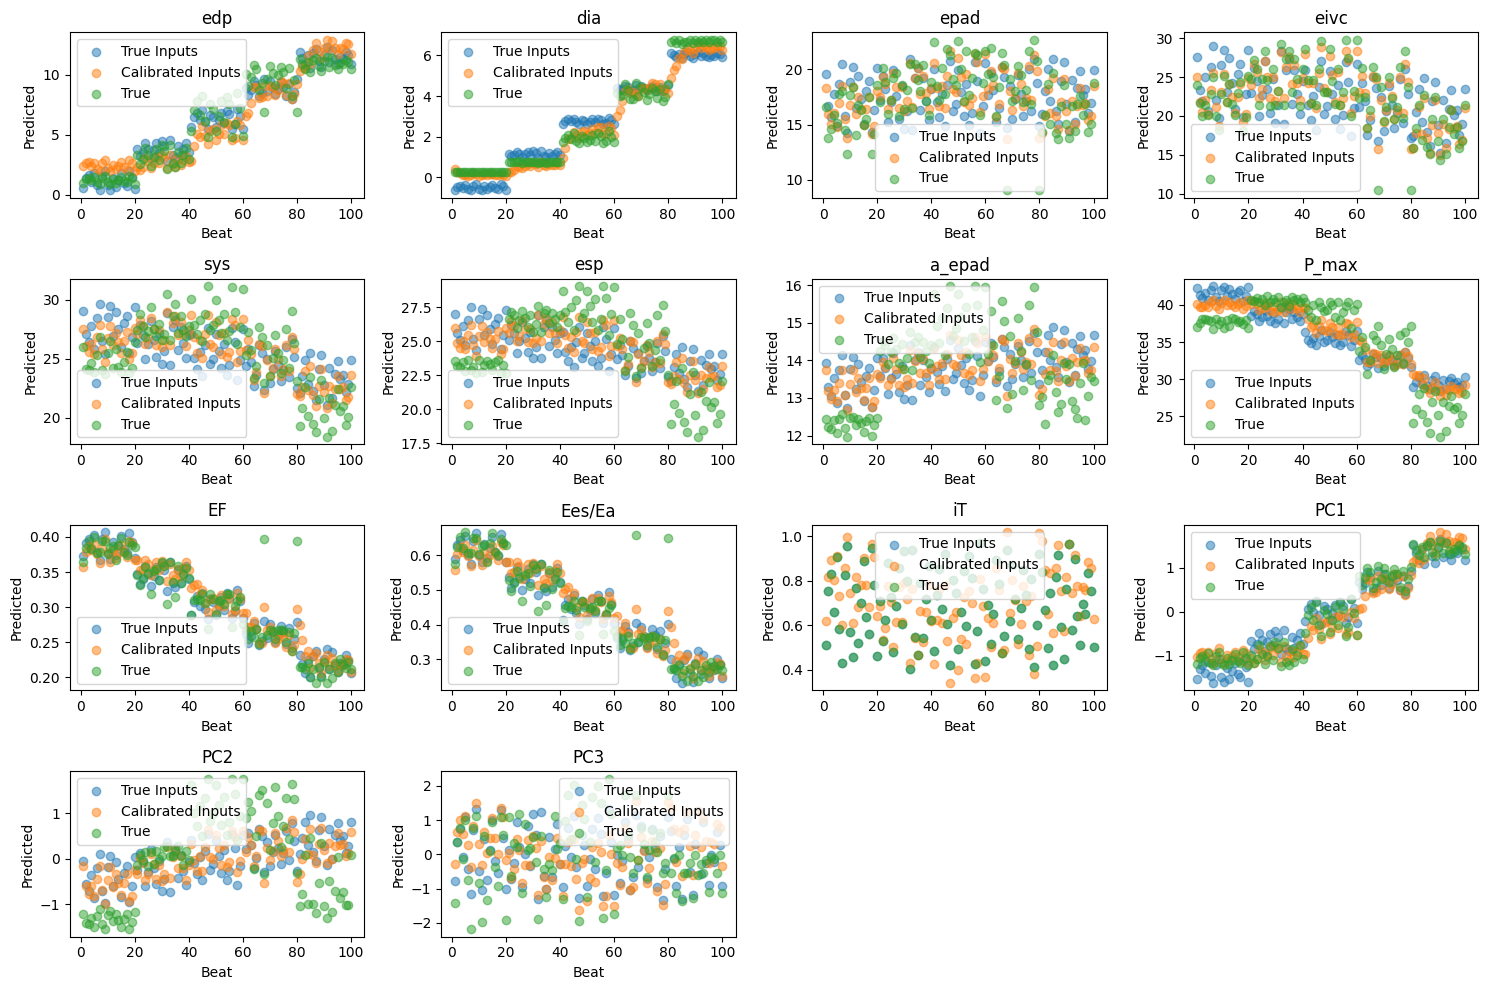

In [7]:
X = np.arange(1,101)
plt.figure(figsize=(15, 10))
for i, key in enumerate(all_output_keys):
    plt.subplot(4, 4, i+1)
    plt.scatter(X, emulator_predictions_true[key], label='True Inputs', alpha=0.5)
    plt.scatter(X, emulator_predictions_calibrated[key], label='Calibrated Inputs', alpha=0.5)
    plt.scatter(X, observation_data[key], label='True', alpha=0.5)
    plt.xlabel('Beat')
    plt.ylabel('Predicted')
    plt.title(key)
    plt.legend()
plt.tight_layout()

In [ ]:
model_error = np.array(emulator_output['RMSE']).reshape(14,1)


(14, 1)